<a href="https://colab.research.google.com/github/kcalizadeh/phil_nlp/blob/master/non_neural_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Imports and Mounting Drive

In [1]:
# this cell mounts drive, sets the correct directory, then imports all functions
# and relevant libraries via the functions.py file
from google.colab import drive
import sys

# install relevent libraries not included with colab
!pip install lime
!pip install symspellpy

drive.mount('/gdrive',force_remount=True)

drive_path = '/gdrive/MyDrive/Colab_Projects/Phil_NLP'

sys.path.append(drive_path)

     |████████████████████████████████| 276kB 4.7MB/s 
  Created wheel for lime: filename=lime-0.2.0.1-cp36-none-any.whl size=283846 sha256=d64b8c7af1bd14c22d995b5324cad2931c87cb0e7722f7cb15d0d963b6d394d2
  Stored in directory: /root/.cache/pip/wheels/4c/4f/a5/0bc765457bd41378bf3ce8d17d7495369d6e7ca3b712c60c89
Successfully built lime
     |████████████████████████████████| 2.6MB 7.0MB/s 
Mounted at /gdrive


In [2]:
from functions import *
%load_ext autoreload
%autoreload 2

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


### Load the data

In [3]:
df = pd.read_csv('/gdrive/MyDrive/Colab_Projects/Phil_NLP/phil_nlp.csv')

df.sample(5)

,title,author,school,sentence_spacy,sentence_str,sentence_length,sentence_lowered,lemmatized_str,tokenized_txt
97793,a treatise of human nature,Hume,empiricism,Any of these past events may again happen; and...,Any of these past events may again happen; and...,140,any of these past events may again happen; and...,any of these past event may again happen ; an...,"['Any', 'of', 'these', 'past', 'events', 'may'..."
19175,complete works,Plato,plato,It fitting that they should be the ones who ru...,It fitting that they should be the ones who ru...,66,it fitting that they should be the ones who ru...,-PRON- fit that -PRON- should be the one who ...,"['It', 'fitting', 'that', 'they', 'should', 'b..."
168490,the logic of scientific discovery,Popper,analytic,I now feel that I should have emphasized in th...,I now feel that I should have emphasized in th...,166,i now feel that i should have emphasized in th...,-PRON- now feel that -PRON- should have empha...,"['I', 'now', 'feel', 'that', 'I', 'should', 'h..."
19096,complete works,Plato,plato,So the rules of the many are the rules of the ...,So the rules of the many are the rules of the ...,55,so the rules of the many are the rules of the ...,so the rule of the many be the rule of the su...,"['So', 'the', 'rules', 'of', 'the', 'many', 'a..."
238539,being and time,Heidegger,phenomenology,The monotony of everydayness takes whatever th...,The monotony of everydayness takes whatever th...,81,the monotony of everydayness takes whatever th...,the monotony of everydayness take whatever th...,"['The', 'monotony', 'of', 'everydayness', 'tak..."


In [4]:
stopwords_list = stopwords.words('english') + list(string.punctuation) + ['“','”','...',"''",'’','``', "'", "‘"]
custom_stopwords = ['–', 'also', 'something', 'cf', 'thus', 'two', 'now', 'would', 'make', 'eb', 'u', 'well', 'even', 'said', 'eg', 'us',
                    'n', 'sein', 'e', 'da', 'therefore', 'however', 'would', 'thing', 'must', 'merely', 'way', 'since', 'latter', 'first',
                    'B', 'mean', 'upon', 'yet', 'cannot', 'c', 'C', 'let', 'may', 'might', "'s", 'b', 'ofthe', 'p.', '_', '-', 'eg', 'e.g.',
                    'ie', 'i.e.', 'f', 'l', "n't", 'e.g', 'i.e', '—', '--', 'hyl', 'phil', 'one'] + stopwords_list

### Baseline NB Bayes Model

In [5]:
# split the data
x_train, x_test, y_train, y_test = train_test_split(df['sentence_str'], df['school'])

In [6]:
# vectorize
tfidvectorizer = TfidfVectorizer(decode_error='ignore', stop_words=custom_stopwords)
tf_idf_data_train = tfidvectorizer.fit_transform(x_train)
tf_idf_data_test = tfidvectorizer.transform(x_test)

In [7]:
# build the classifier, train it, get predictions
nb_classifier = MultinomialNB()
nb_classifier.fit(tf_idf_data_train, y_train)
nb_classifier_preds = nb_classifier.predict(tf_idf_data_test)

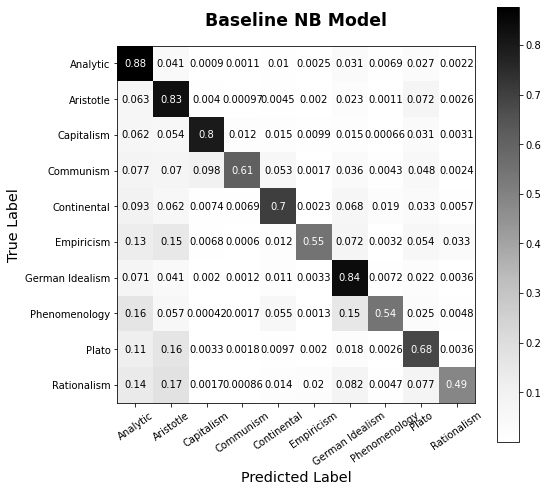

In [8]:
plot_pretty_cf(nb_classifier, tf_idf_data_test, y_test, title='Baseline NB Model')

In [9]:
print(classification_report(y_test, nb_classifier_preds))

                 precision    recall  f1-score   support

       analytic       0.64      0.88      0.74     13356
      aristotle       0.64      0.83      0.72     12396
     capitalism       0.84      0.80      0.82      4544
      communism       0.94      0.61      0.74      4631
    continental       0.83      0.70      0.76      8411
     empiricism       0.90      0.55      0.68      5000
german_idealism       0.71      0.84      0.77     10313
  phenomenology       0.90      0.54      0.68      7117
          plato       0.68      0.68      0.68      9521
    rationalism       0.88      0.49      0.63      5796

       accuracy                           0.73     81085
      macro avg       0.80      0.69      0.72     81085
   weighted avg       0.76      0.73      0.72     81085



Accuracy in the low 70s over 10 classes is not too bad, but we can at least aim higher than this. If we look at it, a lot of failures were along the lines of lines of class imbalance. 

In [10]:
df['school'].value_counts(normalize=True)

analytic           0.165047
aristotle          0.150797
german_idealism    0.128428
plato              0.118084
continental        0.104351
phenomenology      0.088282
rationalism        0.070855
empiricism         0.062642
capitalism         0.056022
communism          0.055492
Name: school, dtype: float64

Perhaps correcting for class imbalance could improve the model. 

### NB Corrected for Class Imbalance

Here we will use imblearn's over and undersampler to correct for class imbalance.

In [11]:
x_train, x_test, y_train, y_test = train_test_split(df['sentence_str'], df['school'])

In [12]:
tfidvectorizer = TfidfVectorizer(decode_error='ignore', stop_words=custom_stopwords)
tf_idf_data_train = tfidvectorizer.fit_transform(x_train)
tf_idf_data_test = tfidvectorizer.transform(x_test)

In [13]:
# from sklearn.preprocessing import LabelEncoder
# from sklearn.utils.class_weight import compute_class_weight, compute_sample_weight

# to use the sampler, the data must be numerical
y_train_dummies = pd.get_dummies(y_train)
y_classes = y_train_dummies.idxmax(1, skipna=False)

le = LabelEncoder()
le.fit(list(y_classes))
y_integers = le.transform(list(y_classes))

# create a dict of labels : their integer representations
label_dict = dict(zip(y_classes, y_integers))
flipped_dict = {value:key for key, value in label_dict.items()}

# # get the class weights
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
sample_weights = compute_sample_weight('balanced', y_integers)
class_weights_dict = dict(zip(le.transform(list(le.classes_)), class_weights))

# convert the target to the numerical categories
y_train = y_train.apply(lambda x: label_dict[x])
y_test = y_test.apply(lambda x: label_dict[x])

#### Oversampling

In [14]:
# from imblearn.under_sampling import RandomUnderSampler
# from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(sampling_strategy='all')

In [15]:
x_under, y_under = ros.fit_sample(tf_idf_data_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [16]:
nb_undersampled = MultinomialNB()
nb_undersampled.fit(x_under, y_under)
nb_undersampled_preds = nb_undersampled.predict(tf_idf_data_test)

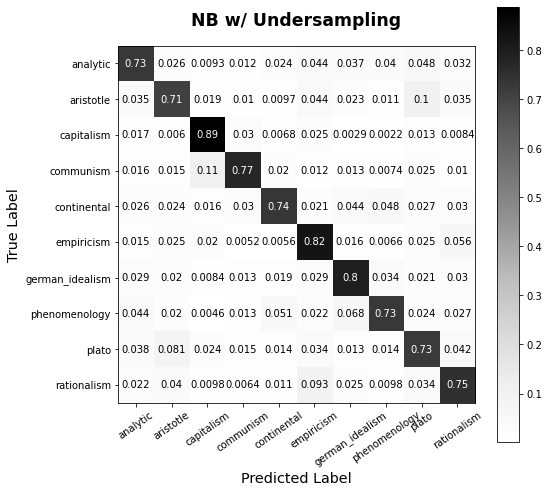

In [17]:
plot_pretty_cf(nb_undersampled, tf_idf_data_test, y_test, 
               title='NB w/ Undersampling', label_dict=flipped_dict)

In [18]:
print(classification_report(y_test, nb_undersampled_preds))

              precision    recall  f1-score   support

           0       0.83      0.73      0.78     13357
           1       0.80      0.71      0.75     12217
           2       0.73      0.89      0.80      4528
           3       0.76      0.77      0.77      4590
           4       0.82      0.74      0.78      8465
           5       0.60      0.82      0.69      5000
           6       0.80      0.80      0.80     10362
           7       0.76      0.73      0.74      7243
           8       0.70      0.73      0.71      9526
           9       0.65      0.75      0.69      5797

    accuracy                           0.75     81085
   macro avg       0.74      0.77      0.75     81085
weighted avg       0.76      0.75      0.75     81085



Not bad, we got a 2% or so increase in accuracy. Let's check if oversampling helps any more.

#### Undersampling

In [19]:
rus = RandomUnderSampler(sampling_strategy='all')

In [20]:
x_over, y_over = rus.fit_sample(tf_idf_data_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [21]:
nb_oversampled = MultinomialNB()
nb_oversampled.fit(x_under, y_under)
nb_oversampled_preds = nb_oversampled.predict(tf_idf_data_test)

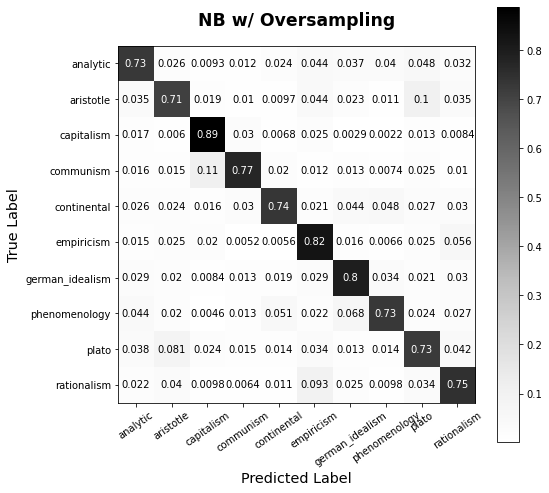

In [22]:
plot_pretty_cf(nb_undersampled, tf_idf_data_test, y_test, 
               title='NB w/ Oversampling', label_dict=flipped_dict)

In [23]:
print(classification_report(y_test, nb_oversampled_preds))

              precision    recall  f1-score   support

           0       0.83      0.73      0.78     13357
           1       0.80      0.71      0.75     12217
           2       0.73      0.89      0.80      4528
           3       0.76      0.77      0.77      4590
           4       0.82      0.74      0.78      8465
           5       0.60      0.82      0.69      5000
           6       0.80      0.80      0.80     10362
           7       0.76      0.73      0.74      7243
           8       0.70      0.73      0.71      9526
           9       0.65      0.75      0.69      5797

    accuracy                           0.75     81085
   macro avg       0.74      0.77      0.75     81085
weighted avg       0.76      0.75      0.75     81085



Unsurprisingly, not much of a different result. It seems like Multinomial Naive Bayes can give us about 75% accuracy. 

It's perhaps worth checking if lemmatization can help the model.

### NB with Lemmatization

In [24]:
x_train, x_test, y_train, y_test = train_test_split(df['lemmatized_str'], df['school'])

# vectorize
tfidvectorizer = TfidfVectorizer(decode_error='ignore', stop_words=custom_stopwords)
tf_idf_data_train = tfidvectorizer.fit_transform(x_train)
tf_idf_data_test = tfidvectorizer.transform(x_test)

In [25]:
y_train_dummies = pd.get_dummies(y_train)
y_classes = y_train_dummies.idxmax(1, skipna=False)

le = LabelEncoder()
le.fit(list(y_classes))
y_integers = le.transform(list(y_classes))

# create a dict of labels : their integer representations
label_dict = dict(zip(y_classes, y_integers))
flipped_dict = {value:key for key, value in label_dict.items()}

# get the class weights
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
sample_weights = compute_sample_weight('balanced', y_integers)
class_weights_dict = dict(zip(le.transform(list(le.classes_)), class_weights))

# convert the target to the numerical categories
y_train = y_train.apply(lambda x: label_dict[x])
y_test = y_test.apply(lambda x: label_dict[x])

In [26]:
rus = RandomUnderSampler(sampling_strategy='all')

x_over_lemma, y_over_lemma = rus.fit_sample(tf_idf_data_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


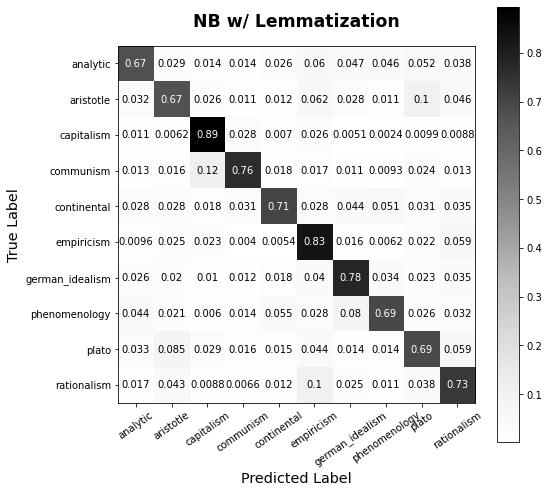

In [27]:
nb_lemma = MultinomialNB()
nb_lemma.fit(x_over_lemma, y_over_lemma)
nb_lemma_preds = nb_lemma.predict(tf_idf_data_test)

plot_pretty_cf(nb_lemma, tf_idf_data_test, y_test, 
               title='NB w/ Lemmatization', label_dict=flipped_dict)

In [28]:
print(classification_report(y_test, nb_lemma_preds))

              precision    recall  f1-score   support

           0       0.84      0.67      0.75     13398
           1       0.78      0.67      0.72     12180
           2       0.70      0.89      0.78      4541
           3       0.75      0.76      0.75      4499
           4       0.81      0.71      0.75      8466
           5       0.53      0.83      0.65      4989
           6       0.78      0.78      0.78     10493
           7       0.73      0.69      0.71      7156
           8       0.68      0.69      0.69      9581
           9       0.59      0.73      0.66      5782

    accuracy                           0.73     81085
   macro avg       0.72      0.74      0.72     81085
weighted avg       0.74      0.73      0.73     81085



Not great, and worse than non-lemmatized versions. This makes sense since lemmatization essentially masks information that might have had some small part to play in the classification math.